In [1]:
from torch import optim
from  torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch
import helper
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batch_size = 128
# Download and load the training data
train_set = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
test_set = datasets.MNIST('MNIST_data/',download=True,train=False,transform=transform)

num_works = 0
valid_split = 0.5
#把test数据集分成test和valid
num_test = len(test_set)#得到数据大小
indices = list(range(num_test))#得到下表索引值列表
#np.random.shuffle(indices)

split = int(np.floor(valid_split*num_test))# 返回不大于输入参数的最大整数。 即对于输入值 x ，将返回最大的整数 i ，使得 i <= x
test_idx,valid_idx = indices[split:],indices[:split] #返回所需的元素索引列表

test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_idx) #样本元素从指定的索引列表中随机抽取，没有替换。参数： - indices (list) – 索引的列表
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False,num_workers=num_works)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False,sampler=test_sampler,num_workers=num_works)
valid_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False,sampler=valid_sampler,num_workers=num_works)

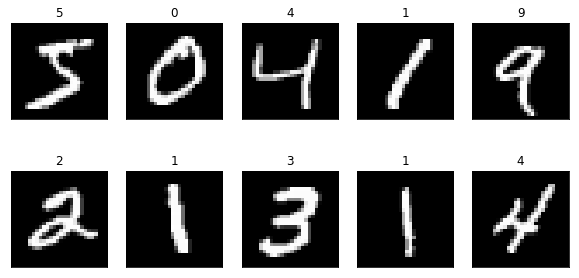

In [4]:
dataiter = iter(train_loader)
images,labels = dataiter.next()

images = images.numpy()

fig = plt.figure(figsize=(10,5),facecolor='white')

for idx in np.arange(10):
    ax = fig.add_subplot(2,10/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    ax.set_title(str(labels[idx].item()))
    plt.savefig("image/figure1.svg")



In [5]:
#更仔细地查看图像
dataiter = iter(train_loader)
images,labels = dataiter.next()

images = images.numpy()
img = np.squeeze(images[0])

fig = plt.figure(figsize=(12,12))
ax.imshow(img,cmap='gray')
width,height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] != 0 else 0
        ax.annotate(str(val),xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color ='white' if img[x][y]<thresh else 'black')
        ax.imshow(img,cmap='gray')


In [27]:
model = nn.Sequential(nn.Linear(784, 512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      )
use_cuda = torch.cuda.is_available()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

if use_cuda:
    model.cuda()

In [28]:
def train(model,epochs,train_loader,valid_loader):
    train_losses_e =[]
    valid_losses_e =[]
    accuracies_e = []
    loss_min = np.inf
    for e in range(epochs):
        running_loss = 0
        train_losses =[]
        valid_losses =[]
        accuracies = []
        for images,labels in train_loader:
            # Flatten MNIST images into a 784 long vector
            if use_cuda:
                images,labels = images.cuda(),labels.cuda()
            images = images.view(images.shape[0], -1)
            optimizer.zero_grad()
            # TODO: Training pass
            output = model(images)
            loss = criterion(output, labels)
            # print(loss)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        model.eval()
        for images,labels in valid_loader:
            if use_cuda:
                images,labels = images.cuda(),labels.cuda()
            images = images.view(images.shape[0],-1)
            out = model(images)
            valid_loss = criterion(out,labels)
            _,index = out.topk(1,dim=1)
            eq = index == labels.view(index.shape)
            accuracy = torch.mean(eq.type(torch.FloatTensor)).item()
            valid_losses.append(valid_loss.item())
            accuracies.append(accuracy)
        train_losses_e.append(np.mean(train_losses))
        valid_losses_e.append(np.mean(valid_losses))
        accuracies_e.append(np.mean(accuracies))
        print(e+1,"/",epochs,"Training loss: {},Valid_loss:{},Valid_accuracy:{}".format(np.mean(train_losses),np.mean(valid_losses),np.mean(accuracies)))
        if loss_min > np.mean(valid_losses):     
            print('Loss decrease...')
            loss_min = np.mean(valid_losses)
            torch.save(model.state_dict(),'model/net_mnist_loss_min_mlp.pth')
            
        
        model.train()
    print('min loss:',loss_min)
    plt.plot(train_losses_e,color='r',label='train_loss')
    plt.plot(valid_losses_e,color='g',label='valid_loss')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('image/loss_mlp.svg')
    return  accuracies_e

1 / 60 Training loss: 0.770151079606527,Valid_loss:0.4577100858092308,Valid_accuracy:0.862109375
Loss decrease...
2 / 60 Training loss: 0.33297715070786504,Valid_loss:0.3820897627621889,Valid_accuracy:0.8837890625
Loss decrease...
3 / 60 Training loss: 0.2740487471492941,Valid_loss:0.3136826574802399,Valid_accuracy:0.90546875
Loss decrease...
4 / 60 Training loss: 0.23110342254516666,Valid_loss:0.2664866603910923,Valid_accuracy:0.918359375
Loss decrease...
5 / 60 Training loss: 0.19782143422980297,Valid_loss:0.2424455691128969,Valid_accuracy:0.9265625
Loss decrease...
6 / 60 Training loss: 0.17195627249793202,Valid_loss:0.20622011311352254,Valid_accuracy:0.93515625
Loss decrease...
7 / 60 Training loss: 0.15145738023335237,Valid_loss:0.1940658027306199,Valid_accuracy:0.9380859375
Loss decrease...
8 / 60 Training loss: 0.13474134354194853,Valid_loss:0.16969874016940595,Valid_accuracy:0.94453125
Loss decrease...
9 / 60 Training loss: 0.12049210157348657,Valid_loss:0.1562754586338997,Vali

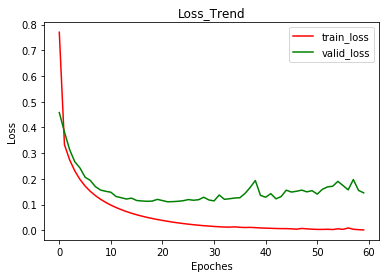

In [29]:
from time import time
start = time()
accuracy = train(model,60,train_loader,valid_loader)
print('Training Time is:',time()-start,'s')

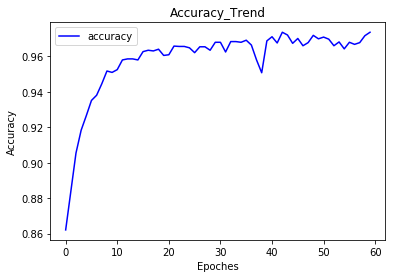

In [30]:
plt.plot(accuracy,color='b',label='accuracy')
plt.title('Accuracy_Trend')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('image/accuracy_mlp.svg')

In [31]:
def test(net,test_loader):
    valid_loss = []
    accuracies_ = []
    net.eval()
    class_correct = np.zeros(10)
    class_total = np.zeros(10)
    classes = ['0','1','2','3','4','5','6','7','8','9']
    for x,y in test_loader:
        if use_cuda:
            x,y = x.cuda(),y.cuda()
        x = x.view(x.shape[0],-1)
        out = net(x)
        loss = criterion(out,y)
        _,class_ = torch.max(out,dim=1)
        equal = class_ == y.view(class_.shape)
        for i in range(y.shape[0]):
            label = y.data[i].item()
            class_correct[label] += equal[i].item()
            class_total[label] += 1
        accuracy = torch.mean(equal.type(torch.FloatTensor)).item()
        accuracies_.append(accuracy)
        
        valid_loss.append(loss.item())
    #print('Test Loss: {:.6f}\n'.format(loss.item()))
    for i in range(10):
        if class_total[i]>0:
            print('Test Accuracy of {}:{:.4f}({}/{})'.format(classes[i],100*class_correct[i]/class_total[i],
                 int(np.sum(class_correct[i])),
                 int(np.sum(class_total[i]))))
        else:
            print('Test Accuracy of {}:N/A(no examples)'.format(classes[i]))
    print('Test Accuracy(Overall):{:.4f} ({}/{})'.format(100*np.sum(class_correct)/np.sum(class_total),
                                                    int(np.sum(class_correct)),
                                                    int(np.sum(class_total))))
    print('Test Loss:',np.mean(valid_loss),'Test Accuracy:',np.mean(accuracies_))

In [32]:
model_test = model
model_test.load_state_dict(torch.load('model/net_mnist_loss_min_mlp.pth'))
test(model_test,test_loader)

Test Accuracy of 0:99.0385(515/520)
Test Accuracy of 1:99.2908(560/564)
Test Accuracy of 2:98.2072(493/502)
Test Accuracy of 3:98.8235(504/510)
Test Accuracy of 4:99.1701(478/482)
Test Accuracy of 5:97.7064(426/436)
Test Accuracy of 6:98.7903(490/496)
Test Accuracy of 7:98.8372(510/516)
Test Accuracy of 8:96.4948(468/485)
Test Accuracy of 9:98.3640(481/489)
Test Accuracy(Overall):98.5000 (4925/5000)
Test Loss: 0.05842438116669655 Test Accuracy: 0.982421875
